# Tutorial: Goal 5 - Validate Parity

This tutorial guides you through validating parity between implementations. We'll:

1. Compare embeddings (Python vs R or precomputed)
2. Compare baseline results (Pearson r, L2)
3. Compute differences and agreement metrics
4. Visualize parity comparisons

## Dataset

We'll use the **Adamson dataset** throughout this tutorial (smallest, fastest dataset).


## 1. Introduction

**Parity Validation** ensures reproducibility by:
- Comparing embeddings across implementations (Python vs R)
- Comparing baseline results (do predictions match?)
- Identifying numerical differences (tolerance and precision)
- Ensuring reproducibility across environments

**Key concepts**:
- **Numerical parity**: Ensuring identical results across implementations
- **Tolerance**: Acceptable numerical difference (e.g., 1e-6 for floating point)
- **Embedding parity**: Comparing embedding spaces (Euclidean distance, cosine similarity)
- **Result parity**: Comparing predictions and metrics (Pearson r, L2)


In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set up paths
NOTEBOOK_DIR = Path.cwd()
EVAL_FRAMEWORK_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "tutorials" else NOTEBOOK_DIR
INPUT_DIR = EVAL_FRAMEWORK_DIR / "tutorials" / "outputs"
OUTPUT_DIR = INPUT_DIR

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ask user: Use real data or synthetic data?
print("="*70)
print("DATA SOURCE SELECTION")
print("="*70)
print("Choose a data source:")
print("  1. Real data: Load from previous notebook outputs (Goals 2 & 3)")
print("  2. Synthetic data: Generate synthetic embeddings and results (no downloads required)")
print()
USE_REAL_DATA = input("Enter choice (1 for real data, 2 for synthetic): ").strip()
USE_REAL_DATA = USE_REAL_DATA == "1" or USE_REAL_DATA.lower() == "real"

if USE_REAL_DATA:
    # Check if embeddings/results exist from previous notebooks
    prev_embeddings = INPUT_DIR / "goal_2_embeddings.npz"
    prev_results = INPUT_DIR / "goal_2_baseline_results.csv"
    if prev_embeddings.exists() or prev_results.exists():
        print(f"\n✓ Found previous outputs")
        if prev_embeddings.exists():
            print(f"  Embeddings: {prev_embeddings}")
        if prev_results.exists():
            print(f"  Results: {prev_results}")
        print("  Will load from previous tutorial outputs")
        USE_PREV_OUTPUT = True
    else:
        USE_PREV_OUTPUT = False
        print("\n⚠ WARNING: Previous outputs not found. Using synthetic data.")
        USE_REAL_DATA = False
else:
    print("\n✓ Using SYNTHETIC DATA (no downloads required)")
    USE_PREV_OUTPUT = False


Generating synthetic embeddings and results for demonstration...
(In practice, you would load Python and R/precomputed embeddings and results)


## 2. Generate/Load Embeddings for Comparison

For this tutorial, we'll generate synthetic embeddings. In practice, you would load Python embeddings and R/precomputed embeddings.


In [2]:
# Generate synthetic embeddings (simulating Python vs R comparison)
np.random.seed(42)
n_genes = 1000
n_perts = 50
embedding_dim = 10

# Python embeddings (reference)
python_gene_emb = np.random.randn(n_genes, embedding_dim)
python_pert_emb = np.random.randn(embedding_dim, n_perts)

# R embeddings (with small differences to simulate numerical precision issues)
# Add small random noise to simulate floating-point differences
noise_level = 1e-5
r_gene_emb = python_gene_emb + np.random.randn(n_genes, embedding_dim) * noise_level
r_pert_emb = python_pert_emb + np.random.randn(embedding_dim, n_perts) * noise_level

print(f"Generated embeddings:")
print(f"  Python gene embeddings: {python_gene_emb.shape}")
print(f"  Python pert embeddings: {python_pert_emb.shape}")
print(f"  R gene embeddings: {r_gene_emb.shape}")
print(f"  R pert embeddings: {r_pert_emb.shape}")


Generated embeddings:
  Python gene embeddings: (1000, 10)
  Python pert embeddings: (10, 50)
  R gene embeddings: (1000, 10)
  R pert embeddings: (10, 50)


## 3. Compare Embeddings

Let's compare embeddings using Euclidean distance and cosine similarity.


In [3]:
# Compute differences
gene_emb_diff = python_gene_emb - r_gene_emb
pert_emb_diff = python_pert_emb - r_pert_emb

# Euclidean distance (L2 norm)
gene_emb_l2 = np.sqrt(np.sum(gene_emb_diff ** 2, axis=1))  # Per gene
pert_emb_l2 = np.sqrt(np.sum(pert_emb_diff ** 2, axis=0))  # Per perturbation

# Mean squared error
gene_emb_mse = np.mean(gene_emb_diff ** 2)
pert_emb_mse = np.mean(pert_emb_diff ** 2)

# Cosine similarity (per gene/perturbation)
gene_emb_cosine = []
for i in range(n_genes):
    cos_sim = cosine_similarity(
        python_gene_emb[i:i+1, :],
        r_gene_emb[i:i+1, :]
    )[0, 0]
    gene_emb_cosine.append(cos_sim)

pert_emb_cosine = []
for i in range(n_perts):
    cos_sim = cosine_similarity(
        python_pert_emb[:, i:i+1].T,
        r_pert_emb[:, i:i+1].T
    )[0, 0]
    pert_emb_cosine.append(cos_sim)

print("Embedding Comparison:")
print("="*60)
print(f"Gene Embeddings:")
print(f"  Mean L2 distance: {gene_emb_l2.mean():.6f}")
print(f"  Max L2 distance: {gene_emb_l2.max():.6f}")
print(f"  Mean MSE: {gene_emb_mse:.6e}")
print(f"  Mean cosine similarity: {np.mean(gene_emb_cosine):.6f}")
print(f"  Min cosine similarity: {np.min(gene_emb_cosine):.6f}")

print(f"\nPerturbation Embeddings:")
print(f"  Mean L2 distance: {pert_emb_l2.mean():.6f}")
print(f"  Max L2 distance: {pert_emb_l2.max():.6f}")
print(f"  Mean MSE: {pert_emb_mse:.6e}")
print(f"  Mean cosine similarity: {np.mean(pert_emb_cosine):.6f}")
print(f"  Min cosine similarity: {np.min(pert_emb_cosine):.6f}")

# Tolerance check
tolerance = 1e-4
gene_parity = np.all(gene_emb_l2 < tolerance)
pert_parity = np.all(pert_emb_l2 < tolerance)

print(f"\nTolerance Check (tolerance={tolerance}):")
print(f"  Gene embeddings match: {gene_parity}")
print(f"  Perturbation embeddings match: {pert_parity}")


Embedding Comparison:
Gene Embeddings:
  Mean L2 distance: 0.000031
  Max L2 distance: 0.000055
  Mean MSE: 1.010421e-10
  Mean cosine similarity: 1.000000
  Min cosine similarity: 1.000000

Perturbation Embeddings:
  Mean L2 distance: 0.000031
  Max L2 distance: 0.000043
  Mean MSE: 9.830585e-11
  Mean cosine similarity: 1.000000
  Min cosine similarity: 1.000000

Tolerance Check (tolerance=0.0001):
  Gene embeddings match: True
  Perturbation embeddings match: True


In [4]:
# Generate synthetic baseline results (simulating Python vs R comparison)
np.random.seed(123)
n_test_perts = 12
test_pert_names = [f"test_pert_{i}" for i in range(n_test_perts)]

# Python results
python_results = {
    "pearson_r": np.random.normal(0.75, 0.10, n_test_perts),
    "l2": np.random.normal(5.0, 0.5, n_test_perts),
}

# R results (with small differences)
noise_level = 0.01
r_results = {
    "pearson_r": python_results["pearson_r"] + np.random.randn(n_test_perts) * noise_level,
    "l2": python_results["l2"] + np.random.randn(n_test_perts) * noise_level,
}

# Clamp values
python_results["pearson_r"] = np.clip(python_results["pearson_r"], -1, 1)
r_results["pearson_r"] = np.clip(r_results["pearson_r"], -1, 1)
python_results["l2"] = np.clip(python_results["l2"], 0, None)
r_results["l2"] = np.clip(r_results["l2"], 0, None)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "perturbation": test_pert_names,
    "python_pearson_r": python_results["pearson_r"],
    "r_pearson_r": r_results["pearson_r"],
    "python_l2": python_results["l2"],
    "r_l2": r_results["l2"],
})

comparison_df["pearson_r_diff"] = comparison_df["python_pearson_r"] - comparison_df["r_pearson_r"]
comparison_df["l2_diff"] = comparison_df["python_l2"] - comparison_df["r_l2"]
comparison_df["pearson_r_abs_diff"] = np.abs(comparison_df["pearson_r_diff"])
comparison_df["l2_abs_diff"] = np.abs(comparison_df["l2_diff"])

print("Baseline Results Comparison:")
print("="*70)
print(comparison_df.head(10))

print(f"\nSummary Statistics:")
print(f"  Pearson r - Mean absolute difference: {comparison_df['pearson_r_abs_diff'].mean():.6f}")
print(f"  Pearson r - Max absolute difference: {comparison_df['pearson_r_abs_diff'].max():.6f}")
print(f"  L2 - Mean absolute difference: {comparison_df['l2_abs_diff'].mean():.6f}")
print(f"  L2 - Max absolute difference: {comparison_df['l2_abs_diff'].max():.6f}")

# Agreement metrics
pearson_r_corr, _ = pearsonr(python_results["pearson_r"], r_results["pearson_r"])
l2_corr, _ = pearsonr(python_results["l2"], r_results["l2"])

print(f"\nAgreement Metrics:")
print(f"  Pearson r correlation: {pearson_r_corr:.6f}")
print(f"  L2 correlation: {l2_corr:.6f}")

# Tolerance check
tolerance_pearson = 0.01
tolerance_l2 = 0.1
pearson_parity = np.all(comparison_df["pearson_r_abs_diff"] < tolerance_pearson)
l2_parity = np.all(comparison_df["l2_abs_diff"] < tolerance_l2)

print(f"\nTolerance Check:")
print(f"  Pearson r matches (tolerance={tolerance_pearson}): {pearson_parity}")
print(f"  L2 matches (tolerance={tolerance_l2}): {l2_parity}")


Baseline Results Comparison:
  perturbation  python_pearson_r  r_pearson_r  python_l2      r_l2  \
0  test_pert_0          0.641437     0.628898   5.745695  5.745723   
1  test_pert_1          0.849735     0.843357   4.680549  4.687431   
2  test_pert_2          0.778298     0.787369   4.778009  4.769214   
3  test_pert_3          0.599371     0.585084   4.782824  4.785661   
4  test_pert_4          0.692140     0.690739   6.102965  6.094911   
5  test_pert_5          0.915144     0.906526   6.093393  6.076116   
6  test_pert_6          0.507332     0.504776   5.502027  5.498118   
7  test_pert_7          0.707109     0.679123   5.193093  5.198831   
8  test_pert_8          0.876594     0.858878   5.368684  5.372070   
9  test_pert_9          0.663326     0.656327   5.745366  5.745248   

   pearson_r_diff   l2_diff  pearson_r_abs_diff  l2_abs_diff  
0        0.012539 -0.000028            0.012539     0.000028  
1        0.006378 -0.006882            0.006378     0.006882  
2       -0.

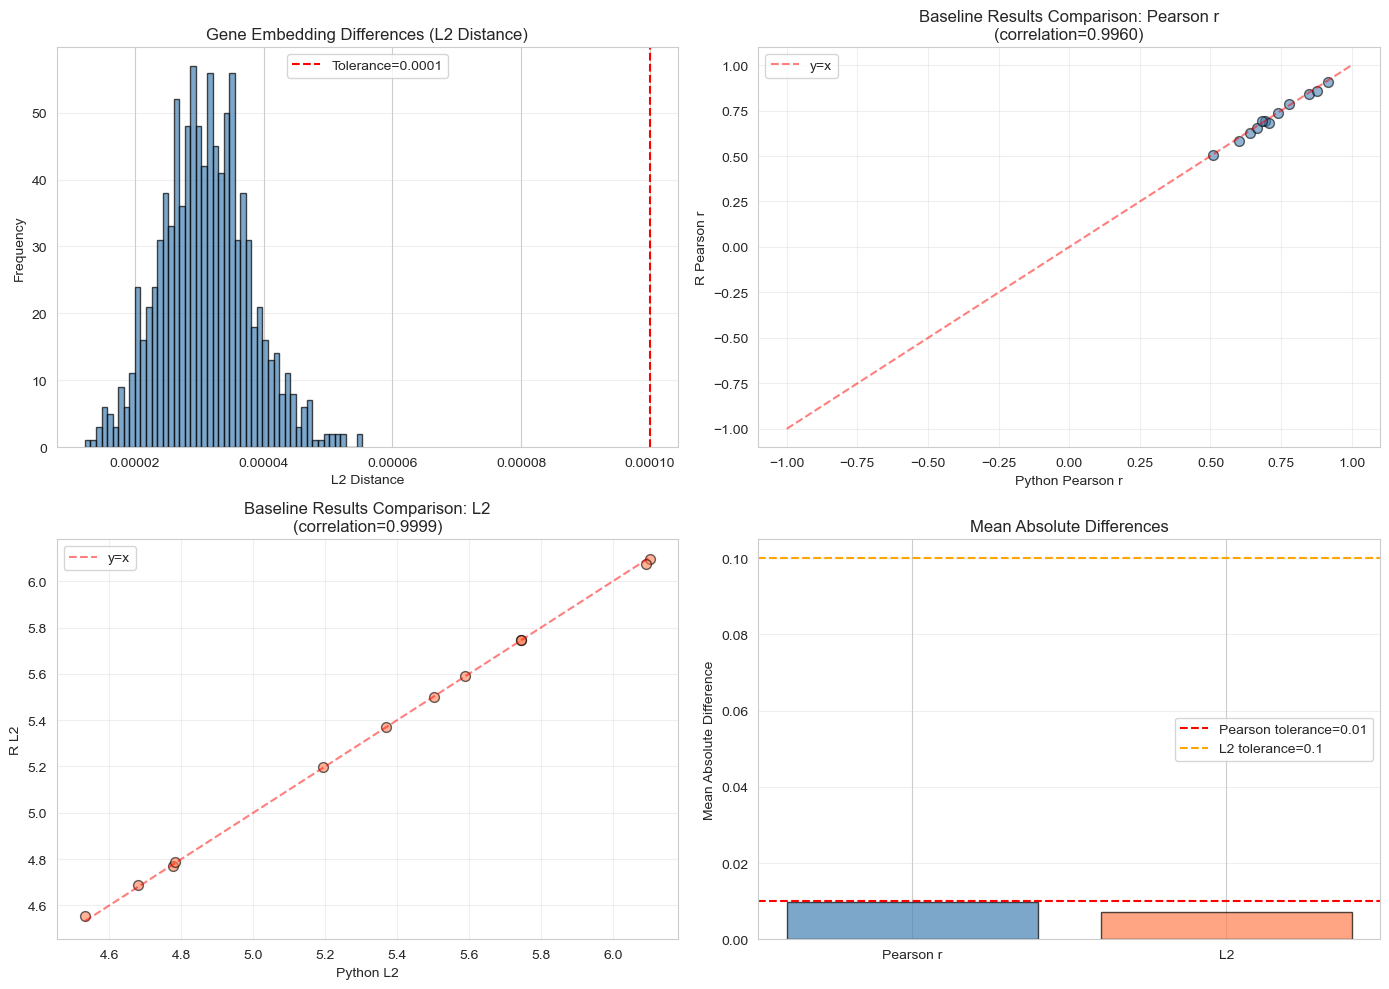

In [5]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Embedding differences (gene embeddings)
axes[0, 0].hist(gene_emb_l2, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(tolerance, color='r', linestyle='--', label=f'Tolerance={tolerance}')
axes[0, 0].set_xlabel('L2 Distance')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Gene Embedding Differences (L2 Distance)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Baseline results comparison (Pearson r)
axes[0, 1].scatter(comparison_df["python_pearson_r"], comparison_df["r_pearson_r"], 
                   alpha=0.6, s=50, color='steelblue', edgecolor='black')
axes[0, 1].plot([-1, 1], [-1, 1], 'r--', alpha=0.5, label='y=x')
axes[0, 1].set_xlabel('Python Pearson r')
axes[0, 1].set_ylabel('R Pearson r')
axes[0, 1].set_title(f'Baseline Results Comparison: Pearson r\n(correlation={pearson_r_corr:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Baseline results comparison (L2)
axes[1, 0].scatter(comparison_df["python_l2"], comparison_df["r_l2"], 
                   alpha=0.6, s=50, color='coral', edgecolor='black')
axes[1, 0].plot([comparison_df["python_l2"].min(), comparison_df["python_l2"].max()], 
                [comparison_df["python_l2"].min(), comparison_df["python_l2"].max()], 
                'r--', alpha=0.5, label='y=x')
axes[1, 0].set_xlabel('Python L2')
axes[1, 0].set_ylabel('R L2')
axes[1, 0].set_title(f'Baseline Results Comparison: L2\n(correlation={l2_corr:.4f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Absolute differences
axes[1, 1].bar(['Pearson r', 'L2'], 
               [comparison_df['pearson_r_abs_diff'].mean(), comparison_df['l2_abs_diff'].mean()],
               alpha=0.7, color=['steelblue', 'coral'], edgecolor='black')
axes[1, 1].axhline(tolerance_pearson, color='r', linestyle='--', label=f'Pearson tolerance={tolerance_pearson}')
axes[1, 1].axhline(tolerance_l2, color='orange', linestyle='--', label=f'L2 tolerance={tolerance_l2}')
axes[1, 1].set_ylabel('Mean Absolute Difference')
axes[1, 1].set_title('Mean Absolute Differences')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
